# Text Classification 
- This is a comprehensive tutorial covering intermediate (and advanced) topics in text classification

In [1]:
%matplotlib inline
import nltk
import matplotlib.pyplot as plt
import csv
import pandas as pd
import sklearn
import numpy as np
from collections import Counter

# feature engineering (words to vectors)
from sklearn.feature_extraction.text import TfidfVectorizer

# classification algorithms (or classifiers)
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, LinearSVC

# build a pipeline
from sklearn.pipeline import Pipeline

# model evaluation, validation
from sklearn.metrics import classification_report, f1_score, accuracy_score, confusion_matrix
from sklearn.model_selection import StratifiedKFold, cross_val_score, train_test_split, GridSearchCV 
from sklearn import metrics
from sklearn.metrics import roc_curve, auc

#pip install scikit-plot 
import scikitplot as skplt

#### Scrape all the data from the website below. It has a really simple xpath and everything should be in the a tag.

https://www.workforce.com/topics/Recruitment/

## Section 1: Data Preprocessing

### Section 1.1: HR Data Acquistion and Preprocessing

In [98]:
# import packages
import requests
from lxml import html
import csv

alldata =[]

web = "https://www.workforce.com/topics/Compensation/page/%s"
for page in range(1,25):
    url = web % page
    data = html.fromstring(requests.get(url).text)
    #xpath
    for i in data.xpath("//div[@class='tm-content']/article"):
        title = i.xpath("header[@class='hcm-archive-title']/h2/a/text()")
        alldata.append([title,summary])
    
len(alldata)

240

In [102]:
import re
cleaned = [i for i in alldata if i not in ['[', ']']]
cleaned = [i for i in cleaned if i not in ['[', ']']]

In [104]:
cleaned[0][0]

[u'Don\u2019t Ignore State Law When Considering Wage-and-Hour Issues']

In [107]:
hr = pd.DataFrame(cleaned)
hr.head()

,0,1
0,[Don’t Ignore State Law When Considering Wage-...,[\n]
1,[Department of Labor Trying to Get Employees P...,[\n]
2,[Save Money on OT Payments With the Fluctuatin...,[\n]
3,"[Employee Blues Can Be Cheered By More Green, ...",[\n]
4,[Can You Pay Your Employees in Bitcoin?],[\n]


In [108]:
hr.drop(1,axis=1,inplace=True)

,0
0,[Don’t Ignore State Law When Considering Wage-...
1,[Department of Labor Trying to Get Employees P...
2,[Save Money on OT Payments With the Fluctuatin...
3,"[Employee Blues Can Be Cheered By More Green, ..."
4,[Can You Pay Your Employees in Bitcoin?]


In [109]:
hr['is_hr_news'] = 1

In [110]:
hr.rename(columns={0:'title'},inplace=True)

,title,is_hr_news
0,[Don’t Ignore State Law When Considering Wage-...,1
1,[Department of Labor Trying to Get Employees P...,1
2,[Save Money on OT Payments With the Fluctuatin...,1
3,"[Employee Blues Can Be Cheered By More Green, ...",1
4,[Can You Pay Your Employees in Bitcoin?],1


In [111]:
hr['title'].apply(', '.join)

0      Don’t Ignore State Law When Considering Wage-a...
1      Department of Labor Trying to Get Employees PA...
2      Save Money on OT Payments With the Fluctuating...
3      Employee Blues Can Be Cheered By More Green, S...
4                 Can You Pay Your Employees in Bitcoin?
5      Talent10x: Which City Will Win Amazon’s Second...
6      Walmart (Yes, Walmart) Has Now Done More for W...
7      Talent10x: Is It Still Better to Work at Big C...
8      Despite Pay Hike, CHROs Still Trail Fellow C-S...
9                      Talent10x: Does Meritocracy Work?
10                        5MM: Lowering the Minimum Wage
11     Is the Labor Department’s White-Collar Salary ...
12     Time Management Clock Ticks Toward Value and A...
13     Don’t Let Off-the-clock Overtime Claims Become...
14     When Is a Settlement not a Settlement? When FL...
15                     When Equal Pay is not ‘Equal’ Pay
16             Wage Theft is a Misnamed, Overused Phrase
17     Working Families Flexibi

In [112]:
hr['title'] = hr['title'].apply(', '.join)
hr.head()

,title,is_hr_news
0,Don’t Ignore State Law When Considering Wage-a...,1
1,Department of Labor Trying to Get Employees PA...,1
2,Save Money on OT Payments With the Fluctuating...,1
3,"Employee Blues Can Be Cheered By More Green, S...",1
4,Can You Pay Your Employees in Bitcoin?,1


In [115]:
hr['title'] = hr['title'].str.strip()

In [116]:
hr['title'] = hr['title'].str.lower()

In [119]:
hr['title'] = hr['title'].str.replace('[^a-zA-Z]+', ' ')

In [120]:
hr['title'] = hr['title'].str.findall('\w{3,}').str.join(' ')

In [121]:
hr.head()

,title,is_hr_news
0,don ignore state law when considering wage and...,1
1,department labor trying get employees paid for...,1
2,save money payments with the fluctuating workweek,1
3,employee blues can cheered more green survey f...,1
4,can you pay your employees bitcoin,1


In [124]:
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

In [125]:
hr['title'] = hr['title'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [126]:
hr.head()

,title,is_hr_news
0,ignore state law considering wage hour issues,1
1,department labor trying get employees paid ina...,1
2,save money payments fluctuating workweek,1
3,employee blues cheered green survey finds,1
4,pay employees bitcoin,1


### Section 1.2: Movie Data Preprocessing

In [136]:
posdf = pd.read_csv('data/top_reviews.csv',usecols=['2'])
posdf.head()

,2
0,Why do I want to write the 234th comment on Th...
1,I have never seen such an amazing film since I...
2,This movie is not your ordinary Hollywood flic...
3,"Can Hollywood, usually creating things for ent..."
4,I'm trying to save you money; this is the last...


In [141]:
negdf = pd.read_csv('data/worst_reviews.csv',usecols=['2'])
negdf.head()

,2
0,After sitting through the entirety of Daddy Da...
1,Daddy Day Care was a sweet and simple movie th...
2,"This is my first comment on IMDb, because i am..."
3,This movie was just awful. The plot is 2 guys ...
4,"Really, I'm only commenting because the origin..."


#### Section 1.2.1: Cleaning the postive reviews

In [137]:
posdf = posdf.rename(columns={'2':'review'})

In [138]:
posdf['review'] = posdf['review'].str.lower()
posdf['review'] = posdf['review'].str.replace("[^a-zA-Z]", " ")
posdf['review'] = posdf['review'].str.findall('\w{3,}').str.join(' ')

from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords = set(stopwords)
stopwords.add('film')
stopwords.add('movie')
stopwords.add('one')
stopwords.add('even')
stopwords.add('really')
stopwords.add('time')
stopwords.add('title')
stopwords.add('first')
stopwords.add('last')
stopwords.add('don')
stopwords.add('could')
stopwords.add('many')
stopwords.add('much')
stopwords.add('also')
stopwords.add('might')
stopwords.add('should')
stopwords.add('films')
stopwords.add('movies')
stopwords.add('way')
stopwords.add('ever')
stopwords.add('would')

posdf['review'] = posdf['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [139]:
posdf.head()

,review
0,want write comment shawshank redemption sure a...
1,never seen amazing since saw shawshank redempt...
2,ordinary hollywood flick great deep message fo...
3,hollywood usually creating things entertainmen...
4,trying save money consider borrowing renting s...


In [140]:
posdf['is_hr_news'] = 0

#### Section 1.2.2: Cleaning the negative reviews

In [142]:
negdf = negdf.rename(columns={'2':'review'})

In [143]:
negdf['review'] = negdf['review'].str.lower()
negdf['review'] = negdf['review'].str.replace("[^a-zA-Z]", " ")
negdf['review'] = negdf['review'].str.findall('\w{3,}').str.join(' ')

from nltk.corpus import stopwords
stopwords = stopwords.words('english')
stopwords = set(stopwords)
stopwords.add('film')
stopwords.add('movie')
stopwords.add('one')
stopwords.add('even')
stopwords.add('really')
stopwords.add('time')
stopwords.add('title')
stopwords.add('first')
stopwords.add('last')
stopwords.add('don')
stopwords.add('could')
stopwords.add('many')
stopwords.add('much')
stopwords.add('also')
stopwords.add('might')
stopwords.add('should')
stopwords.add('films')
stopwords.add('movies')
stopwords.add('way')
stopwords.add('ever')
stopwords.add('would')


negdf['review'] = negdf['review'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)]))

In [144]:
negdf['is_hr_news'] = 0

#### Section 1.2.3: Combining the movie data with the hr data

In [146]:
hr.rename(columns={'title':'review'},inplace=True)

In [147]:
frames = [posdf,negdf,hr]

hr1 = pd.concat(frames)

hr1.head()

,review,is_hr_news
0,want write comment shawshank redemption sure a...,0
1,never seen amazing since saw shawshank redempt...,0
2,ordinary hollywood flick great deep message fo...,0
3,hollywood usually creating things entertainmen...,0
4,trying save money consider borrowing renting s...,0


In [148]:
len(hr1)

1641

In [149]:
len(posdf)

671

In [150]:
len(negdf)

730

In [151]:
len(hr)

240

In [153]:
hr1.groupby('is_hr_news').size()

is_hr_news
0    1401
1     240
dtype: int64

In [160]:
hr1 = hr1.reset_index(drop=True)

In [166]:
hr1.to_csv('hrandmovie.csv')

In [167]:
hr1.head()

,review,is_hr_news
0,want write comment shawshank redemption sure a...,0
1,never seen amazing since saw shawshank redempt...,0
2,ordinary hollywood flick great deep message fo...,0
3,hollywood usually creating things entertainmen...,0
4,trying save money consider borrowing renting s...,0


## Section 2: Building DTM and Feature Extraction and Selection

In [2]:
hr_data = []
hr_labels = []
hr = []

openfile = open('data/hrandmovie.csv', 'rb')
r = csv.reader(openfile)
for i in r:
    hr.append(i)
    hr_data.append(i[1])
    hr_labels.append(i[2])    
openfile.close()

In [3]:
tfidf_vectorizer = TfidfVectorizer(decode_error ='ignore')
tfidf = tfidf_vectorizer.fit_transform(hr_data)
print tfidf.shape
print tfidf

(1642, 18556)
  (0, 13709)	1.0
  (1, 17960)	0.04689112137285809
  (1, 18414)	0.07081044152214631
  (1, 3048)	0.07322940602356301
  (1, 14684)	0.3254817041549533
  (1, 13295)	0.38506885567130605
  (1, 16126)	0.053358729099798566
  (1, 436)	0.05101517179686144
  (1, 5626)	0.050219340025167834
  (1, 12378)	0.0666196367985419
  (1, 14111)	0.20857296456417276
  (1, 9537)	0.08572040638609364
  (1, 11900)	0.03594452315604999
  (1, 18425)	0.07564837052497969
  (1, 3053)	0.06987795685952464
  (1, 12673)	0.10376503245599931
  (1, 10694)	0.09574905061479913
  (1, 14904)	0.063717797034765
  (1, 5235)	0.11464204205407882
  (1, 4250)	0.08938640787993851
  (1, 7844)	0.05870203902761957
  (1, 6608)	0.08337641386912183
  (1, 14455)	0.1145382381837234
  (1, 5149)	0.10203034359372289
  (1, 15857)	0.0928880228579198
  :	:
  (1639, 15438)	0.2944681834925156
  (1639, 10382)	0.5742637805335631
  (1639, 9215)	0.32521380392941707
  (1639, 3376)	0.4236541227030305
  (1639, 3394)	0.4236541227030305
  (1640, 9392

In [4]:
tfidf_vectorizer.get_feature_names()

[u'aaaaaaah',
 u'aaargh',
 u'aah',
 u'aahhhh',
 u'aargh',
 u'aaron',
 u'aaw',
 u'abandon',
 u'abandonded',
 u'abandoned',
 u'abandons',
 u'abbott',
 u'abbreviated',
 u'abby',
 u'abc',
 u'abducted',
 u'abducting',
 u'aberrations',
 u'abhorred',
 u'abhorrent',
 u'abiding',
 u'abilities',
 u'ability',
 u'abject',
 u'able',
 u'ably',
 u'abnormally',
 u'aboard',
 u'abolish',
 u'abolishing',
 u'abominable',
 u'abomination',
 u'aborted',
 u'abortion',
 u'abound',
 u'abraham',
 u'abrahams',
 u'abrasive',
 u'abrupt',
 u'abscessed',
 u'absence',
 u'absent',
 u'absolom',
 u'absolute',
 u'absolutely',
 u'absorb',
 u'absorbed',
 u'absorbing',
 u'absorbs',
 u'abstaining',
 u'abstract',
 u'abstracting',
 u'abstraction',
 u'abstruse',
 u'absurd',
 u'absurdities',
 u'absurdity',
 u'absurdly',
 u'abundance',
 u'abundant',
 u'abuse',
 u'abused',
 u'abuser',
 u'abusers',
 u'abusive',
 u'abysmal',
 u'abysmally',
 u'abyss',
 u'academy',
 u'accelerated',
 u'accent',
 u'accented',
 u'accents',
 u'accentuates'

In [5]:
hr[:5]

[['', 'review', 'is_hr_news'],
 ['0',
  'want write comment shawshank redemption sure almost everything possibly said said like people wrote comments profoundly moved simple eloquent depiction hope friendship redemption seen effects strongly kill mockingbird leave feeling cleaner watched intend see like prison normally watch work branch library day checking shawshank redemption older patrons said whenever feel depressed check watch always makes feel better thought strange day nothing except things absolutely watch circumstance things seen times already remembered said watched watched times since gets better every showing action special effects men prison uniforms talking shawshank redemption kill mockingbird best seen judge technical merits care read citizen kane godfather best made may best technique influential motion pictures made best best ones touch soul takes like shawshank redemption touch soul',
  '0'],
 ['1',
  'never seen amazing since saw shawshank redemption shawshank encom

In [6]:
import numpy as np

tfidf_matrix = tfidf_vectorizer.fit_transform(hr_data).toarray()
tfidf_matrix

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [7]:
pd.DataFrame(tfidf_matrix,index=hr_data,columns=tfidf_vectorizer.get_feature_names()).head()

,aaaaaaah,aaargh,aah,aahhhh,aargh,aaron,aaw,abandon,abandonded,abandoned,...,zones,zoo,zoom,zooming,zooms,zsg,zucker,zulu,zzzzzz,zzzzzzzzzzz
review,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
want write comment shawshank redemption sure almost everything possibly said said like people wrote comments profoundly moved simple eloquent depiction hope friendship redemption seen effects strongly kill mockingbird leave feeling cleaner watched intend see like prison normally watch work branch library day checking shawshank redemption older patrons said whenever feel depressed check watch always makes feel better thought strange day nothing except things absolutely watch circumstance things seen times already remembered said watched watched times since gets better every showing action special effects men prison uniforms talking shawshank redemption kill mockingbird best seen judge technical merits care read citizen kane godfather best made may best technique influential motion pictures made best best ones touch soul takes like shawshank redemption touch soul,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
never seen amazing since saw shawshank redemption shawshank encompasses friendships hardships hopes dreams great moves gives hope though circumstances characters viewers quite different feel far removed characters going simple yet everlasting message frank darabont need put kind outlandish special effects get love narration acting win seven oscars beyond let sway see let ranking imdb top list sway let friends recommendation sway set aside little two hours tonight rent finally understand everyone talking understand favorite,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
ordinary hollywood flick great deep message foundation kept built foundation hope message acting phenomenal tim robbins gave greatest performances inspiring intelligent positive performance made smile robbins plays andy dufresne wrongfully convicted murdering wife lover gets life sentences yet never gives hope becomes friends ellis boyd red redding played morgan freeman freeman gives finest performance career unlike robbins lost hope deep regret crime committed deflecting pain away trying feel anything friendship andy learns without hopes dreams nothing andy becomes friends rest red group james whitmore gave great performance brooks halten gets prison parole words red institutionalized directing frank darabont magnificent kept great steady pace along writing great cinematography portrayed prison life horrifying terms physical pain stress pain wares mentally inmates deserve second chance whatever listen people say overrated inspiring greatest everything possibly want,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
hollywood usually creating things entertainment purposes create art create something nature director must approach meticulous manner due delicacy process daunting task requires extremely capable artist undeniable managerial capacity acutely developed awareness element art prominent music visuals script acting elements equally important must succeed independently yet still form harmonious union mixture determines fate artist opus though already well known amongst colleagues notable skills writing directing frank darabont emerges feature directorial debut shawshank redemption proving already master craft darabont managed create recognizable independent releases history hollywood shawshank redemption defines genre defies odds compels emotions brings era artistically influential back hollywood story begins trial young banker andy dufrense victimized circumstantial evidence resulting conviction murder wife lover quick conviction andy finds serving life sentence shawshank prison hope parole exists prison appearance keeping mind free drab walls around ability results gaining respect fellow inmates ellis redding ellis comm

## Section 3: Training and Building Models

### Section 3.1: Training our model

In [8]:
x_train, x_test, y_train, y_test = train_test_split(hr_data, hr_labels, test_size=0.2, random_state=0)
len(x_train), len(y_train), len(x_test), len(y_test)

(1313, 1313, 329, 329)

In [9]:
X_train = tfidf_vectorizer.fit_transform(x_train)
X_test = tfidf_vectorizer.transform(x_test)
print X_train[:2]
print "+++++++++++++++++++++++++++++++++++++++++"
print X_test[:2]

  (0, 10125)	0.09050034132838855
  (0, 265)	0.49496662707714634
  (0, 13097)	0.17339214915151815
  (0, 11624)	0.19124260246422098
  (0, 12969)	0.18686886172799838
  (0, 15496)	0.14054423608560954
  (0, 13280)	0.1670210465951188
  (0, 15268)	0.14521039960389884
  (0, 11459)	0.22963286022587034
  (0, 1274)	0.2090930557769238
  (0, 1180)	0.14054423608560954
  (0, 8196)	0.12711123123031845
  (0, 9571)	0.19904020180036883
  (0, 14058)	0.18487149990782162
  (0, 4657)	0.18487149990782162
  (0, 5659)	0.13691712786428978
  (0, 404)	0.11269557199518761
  (0, 5641)	0.1046039093371481
  (0, 10744)	0.181189748487666
  (0, 14205)	0.22963286022587034
  (0, 15880)	0.17785919920495855
  (0, 8190)	0.12258475204939935
  (0, 11906)	0.1763058626542425
  (0, 12150)	0.1962431639270234
  (0, 2026)	0.13363135029627188
  :	:
  (1, 6695)	0.08074556539310425
  (1, 2491)	0.10843794541213853
  (1, 10241)	0.13307608863821835
  (1, 14001)	0.10634462715052476
  (1, 16691)	0.25173978740178304
  (1, 14182)	0.11488503171

### Section 3.2: Naive Bayes Classifier Pipeline

In [10]:
# a complete pipeline

nb_pipeline = Pipeline([('tfidf', TfidfVectorizer(decode_error ='ignore')), ('clf', MultinomialNB())])
nb_pipeline = nb_pipeline.fit(x_train, y_train)
predicted = nb_pipeline.predict(x_test)
np.mean(predicted == y_test)  

0.8936170212765957

In [11]:
print '\n overall accuracy:'
print metrics.accuracy_score(y_test, predicted)

print '\n confusion_matrix:'
print metrics.confusion_matrix(y_test, predicted)

print '\n Here is the classification report:'
print metrics.classification_report(y_test, predicted)


 overall accuracy:
0.8936170212765957

 confusion_matrix:
[[288   0]
 [ 35   6]]

 Here is the classification report:
             precision    recall  f1-score   support

          0       0.89      1.00      0.94       288
          1       1.00      0.15      0.26        41

avg / total       0.91      0.89      0.86       329



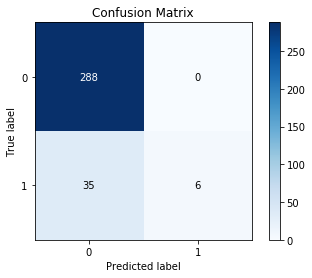

In [12]:
skplt.metrics.plot_confusion_matrix(y_true=np.array(y_test), y_pred=predicted)
plt.show()

### Section 3.3: K-NN Classifier

In [13]:
### kNeighbors Classifier (kNN)
from sklearn.neighbors import KNeighborsClassifier


knn_pipeline = Pipeline([('tfidf', TfidfVectorizer(decode_error ='ignore')), ('clf', KNeighborsClassifier())])
knn_pipeline = knn_pipeline.fit(x_train, y_train)
predicted = knn_pipeline.predict(x_test)
np.mean(predicted == y_test) 

0.9817629179331308

In [14]:
print '\n overall accuracy:'
print metrics.accuracy_score(y_test, predicted)

print '\n confusion_matrix:'
print metrics.confusion_matrix(y_test, predicted)

print '\n Here is the classification report:'
print metrics.classification_report(y_test, predicted)


 overall accuracy:
0.9817629179331308

 confusion_matrix:
[[287   1]
 [  5  36]]

 Here is the classification report:
             precision    recall  f1-score   support

          0       0.98      1.00      0.99       288
          1       0.97      0.88      0.92        41

avg / total       0.98      0.98      0.98       329



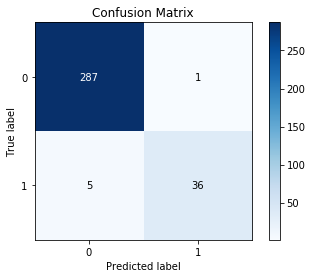

In [15]:
skplt.metrics.plot_confusion_matrix(y_true=np.array(y_test), y_pred=predicted)
plt.show()

### Section 3.4: Support Vector Classifier

In [16]:
### Support Vector Classifier

svm_pipeline = Pipeline([('tfidf', TfidfVectorizer(decode_error ='ignore')), ('clf', SVC(kernel='linear', probability=True))])
svm_pipeline = svm_pipeline.fit(x_train, y_train)
predicted = svm_pipeline.predict(x_test)
np.mean(predicted == y_test)

0.9908814589665653

In [17]:
print '\n overall accuracy:'
print metrics.accuracy_score(y_test, predicted)

print '\n confusion_matrix:'
print metrics.confusion_matrix(y_test, predicted)

print '\n Here is the classification report:'
print metrics.classification_report(y_test, predicted)


 overall accuracy:
0.9908814589665653

 confusion_matrix:
[[288   0]
 [  3  38]]

 Here is the classification report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99       288
          1       1.00      0.93      0.96        41

avg / total       0.99      0.99      0.99       329



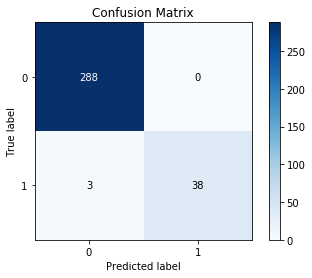

In [18]:
skplt.metrics.plot_confusion_matrix(y_true=np.array(y_test), y_pred=predicted)
plt.show()

#### Based on the above results, the Support Vector Classifier is the best model. It has the highest accuracy, best confusion matrix, and a high f1 score.

## Section 4: Model Deployment

### Section 4.1: Getting new unlabeled HR/Non HR data

In [23]:
unlabeled_data = ['OSHA introduces new safety regulations into the workplace',
                  'The Kansas City Chiefs lose to the New England Patriots on a last second field goal',
                 'Workers compensation claims rise from last year',
                 'West Virginia Teachers Unions successfully strike for higher wages',
                 'Democrats are likely going to win back the House of Representatives',
                 'Lawmakers discuss increasing the minimum wage, what this means for your business',
                 'OSHA orders burlington northern to pay whistle blower',
                 'Climate Change might cause this winter to be warmer and shorter than usual',
                 'Python overtakes R as the most popular programming language for data science',
                 'Elizabeth Warren considering a 2020 presidential run',
                 'The BLS says that fewer companies are hiring in 2018',
                 'New law regarding unemployment benefits might cost companies more money',
                 'Some Kansas lawmakers propose bill that would legalize marijuana']

### Section 4.2: Deploying the SVC

In [24]:
svm = SVC(kernel='linear',probability=True).fit(X_train, y_train)

predicted = svm.predict(X_test)
np.mean(predicted == y_test)  

0.9908814589665653

In [25]:
unlabeled_tfidf = tfidf_vectorizer.transform(unlabeled_data)

predicted = svm.predict(unlabeled_tfidf)

for doc, category in zip(unlabeled_data, predicted):
    print('%r => %s' % (doc, category))

'OSHA introduces new safety regulations into the workplace' => 1
'The Kansas City Chiefs lose to the New England Patriots on a last second field goal' => 1
'Workers compensation claims rise from last year' => 1
'West Virginia Teachers Unions successfully strike for higher wages' => 1
'Democrats are likely going to win back the House of Representatives' => 0
'Lawmakers discuss increasing the minimum wage, what this means for your business' => 1
'OSHA orders burlington northern to pay whistle blower' => 1
'Climate Change might cause this winter to be warmer and shorter than usual' => 0
'Python overtakes R as the most popular programming language for data science' => 1
'Elizabeth Warren considering a 2020 presidential run' => 0
'The BLS says that fewer companies are hiring in 2018' => 1
'New law regarding unemployment benefits might cost companies more money' => 1
'Some Kansas lawmakers propose bill that would legalize marijuana' => 1


In [22]:
#Finding the predicted probabilities

predicted_prob = svm.predict_proba(unlabeled_tfidf)

for doc, category in zip(unlabeled_data, predicted_prob):
    print('%r => %s' % (doc, category))

'OSHA introduces new safety regulations into the workplace' => [0.00416241 0.9929901  0.00284749]
'The Kansas City Chiefs lose to the New England Patriots' => [0.03496845 0.9623258  0.00270574]
'Workers compensation claims rise from last year' => [4.90583374e-04 9.88184389e-01 1.13250273e-02]
'West Virginia Teachers Unions successfully strike for higher wages' => [3.98925990e-05 9.96802940e-01 3.15716748e-03]
'Democrats are likely going to win back the House of Representatives' => [0.27761053 0.72042254 0.00196693]
'Lawmakers discuss increasing the minimum wage, what this means for your business' => [6.51608537e-05 9.95863857e-01 4.07098237e-03]
'OSHA orders burlington northern to pay whistle blower' => [4.98330083e-05 9.96393184e-01 3.55698325e-03]
'Climate Change might cause this winter to be warmer and shorter than usual' => [0.22288369 0.7753352  0.00178111]
'Python overtakes R as the most popular language for data science' => [0.00215441 0.994993   0.00285259]
'Elizabeth Warren co

## Section 5: Story Telling

#### So based on our analysis, we tested 3 different kinds of classification models on our HR data to see which one can best and most accurately classify news articles as being a HR article, or not a HR article. Based on the accuracy and F-1 scores of each model, I would say that the support vector classifier model was the best model out of the 3. It was able to correctly classify news articles more often than the other two models. What this means for managers is that if this tool were deployed, it would correctly classify news articles as HR or not about 99% of the time, meaning that if managers only wanted to see news articles about HR related topics, they would almost always only get articles about HR. The model does have its limitations however, because we didnt have time to collect a sufficient amount of data to really train this model sufficiently. The model will undoubtedly classify things that are clearly not HR news articles as being HR news every once in a while.

## Section 6: Building a Neural Network Multi Layer Perceptron Classifier

In [27]:
from sklearn.neural_network import MLPClassifier

In [28]:
mlp = MLPClassifier(hidden_layer_sizes=(100, ), activation='relu', solver='adam', alpha=0.0001)

In [29]:
mlp.fit(X_train,y_train)

MLPClassifier(activation='relu', alpha=0.0001, batch_size='auto', beta_1=0.9,
       beta_2=0.999, early_stopping=False, epsilon=1e-08,
       hidden_layer_sizes=(100,), learning_rate='constant',
       learning_rate_init=0.001, max_iter=200, momentum=0.9,
       nesterovs_momentum=True, power_t=0.5, random_state=None,
       shuffle=True, solver='adam', tol=0.0001, validation_fraction=0.1,
       verbose=False, warm_start=False)

In [30]:
predictions = mlp.predict(X_test)
print(confusion_matrix(y_test,predictions))

[[288   0]
 [  2  39]]


In [31]:
print(classification_report(y_test,predictions))

             precision    recall  f1-score   support

          0       0.99      1.00      1.00       288
          1       1.00      0.95      0.97        41

avg / total       0.99      0.99      0.99       329



##### On my honor as a student, I have neither given nor received any unauthorized aid on this academic work

Eric VanMeerhaeghe